In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import struct

FILE_TRAIN_IMG = 'MNIST/train-images-idx3-ubyte'
FILE_TRAIN_LBL = 'MNIST/train-labels-idx1-ubyte'
FILE_TEST_IMG = 'MNIST/t10k-images-idx3-ubyte'
FILE_TEST_LBL = 'MNIST/t10k-labels-idx1-ubyte'

# 0 T-shirt/top 1 Trouser
# 2 Pullover    3 Dress
# 4 Coat        5 Sandal
# 6 Shirt       7 Sneaker
# 8 Bag         9 Ankle boot
FILE_FASHION_TRAIN_IMG = 'MNIST-FASHION/train-images-idx3-ubyte'
FILE_FASHION_TRAIN_LBL = 'MNIST-FASHION/train-labels-idx1-ubyte'
FILE_FASHION_TEST_IMG = 'MNIST-FASHION/t10k-images-idx3-ubyte'
FILE_FASHION_TEST_LBL = 'MNIST-FASHION/t10k-labels-idx1-ubyte'

with open(FILE_FASHION_TRAIN_IMG, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows * ncols))
    m, n = data.shape # m: num of rows n: num of pixels
    data = data.T
    data = data / 255.

# open the label file for validation
with open(FILE_FASHION_TRAIN_LBL,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


In [92]:
# layer 0: input layer
#   784 nodes - 1 per pixel
# layer 1: hidden layer
#   10 nodes - 1 per digit
# layer 2: output layer
#   10 nodes - 1 per digit

# Training the network
# 1) Forward propagation
#   A[0] = x; // pass an image through the network and compute output
#   Z[1] = W[1]A[0] + b[1]; // multiply by a weight and add a constant bias
#   activation function - w/o this step, each node would just be a linear combination of the previous nodes
#   tansh or sigmoid function are common activation functions - but we'll use relu
#   relu - rectified linear unit - g(x) = x > 0 ? x : 0;
#   A[1] = relu(Z[1])
#   another activation function for our 2nd layer
#   softmax - pick the best of our options for the output layer
#   softmax(node z) = (e^z) / (sum(e^z)); // weight of current node divided by the total weight of all nodes

# generate random arrays of floats for initial weights and biases
# subtract 0.5 to normalize over -0.5 - 0.5
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def relu(Z):
    return np.maximum(Z, 0)

def relu_deriv(Z):
    return Z > 0

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# "one-hot encoding" create a 1xm matrix with only one "bit" flipped
# Y will be our labels matrix
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

# 2) Backwards propagation
#   find the error across layers
#   let dZ[2] be the error of the 2nd layer
#   dZ[2] = A - Y
#   dW[2] = 1/m * dZ[2]A[1]T
#   db[2] = 1/m * sum(dz[2])
#   dZ[1] = W[2]T * dZ[2] .* g'(Z[0]) // g' is the derivative of the activation function g(x)
#   dW[1] = 1/m * dZ[1] * XT
#   db[1] = 1/m * sum(dZ[1])

# A2: our predictions
def backward_prop(Z1, A1, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * relu_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)
    return dW1, db1, dW2, db2

# 3) Update parameters
#   W[1] = W[1] - a * dW[1]
#   b[1] = b[1] - a * db[1]
#   w[2] = W[2] - a * dW[2]
#   b[2] = b[2] - a * db[2]
#   where a is some learning rate. this is a parameter you set, not gradient descent
#   .2 is our best alpha for MNIST and .1 for FASHION

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


In [93]:
# the fun part
def gradient_descent(W1, b1, W2, b2, X, Y, alpha, iterations):
    """X: our training data
    Y: the labels for the data
    alpha: learning rate
    iterations: number of iterations"""
    for i in range(iterations): # main training loop
        Z1, A1, _, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % (iterations // 20) == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    print("Training complete.")
    print(get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

def test(W1, b1, W2, b2, X, Y):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    print("Testing complete.")
    print(get_accuracy(get_predictions(A2), Y), "final accuracy.")

def make_predictions(W1, b1, W2, b2, X):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

def test_prediction(index, W1, b1, W2, b2, X, Y):
    current_image = X[:, index, None]
    prediction = make_predictions(W1, b1, W2, b2, current_image)
    label = Y[index]
    print("Prediction:", prediction)
    print("Label:", label)
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

with open(FILE_FASHION_TEST_IMG, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_data = test_data.reshape((size, nrows * ncols))
    test_data = test_data.T
    test_data = test_data / 255.

with open(FILE_FASHION_TEST_LBL,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


In [99]:
W1, b1, W2, b2 = init_params()
W1, b1, W2, b2 = gradient_descent(W1, b1, W2, b2, data, labels, 0.10, 1000)


Iteration:  0
[2 6 6 ... 2 6 2] [9 0 0 ... 3 0 5]
0.10696666666666667
Iteration:  50
[9 0 0 ... 1 0 5] [9 0 0 ... 3 0 5]
0.47186666666666666
Iteration:  100
[9 0 3 ... 1 0 5] [9 0 0 ... 3 0 5]
0.5615166666666667
Iteration:  150
[9 0 3 ... 1 0 5] [9 0 0 ... 3 0 5]
0.5981
Iteration:  200
[9 0 3 ... 1 0 5] [9 0 0 ... 3 0 5]
0.619
Iteration:  250
[9 0 3 ... 3 0 5] [9 0 0 ... 3 0 5]
0.6310333333333333
Iteration:  300
[9 0 3 ... 3 0 5] [9 0 0 ... 3 0 5]
0.6308833333333334
Iteration:  350
[9 0 3 ... 3 0 5] [9 0 0 ... 3 0 5]
0.6177666666666667
Iteration:  400
[9 0 3 ... 3 6 5] [9 0 0 ... 3 0 5]
0.6350333333333333
Iteration:  450
[9 0 3 ... 3 2 5] [9 0 0 ... 3 0 5]
0.68275
Iteration:  500
[9 0 3 ... 3 2 5] [9 0 0 ... 3 0 5]
0.7071166666666666
Iteration:  550
[9 0 3 ... 3 6 5] [9 0 0 ... 3 0 5]
0.7216
Iteration:  600
[9 0 3 ... 3 6 5] [9 0 0 ... 3 0 5]
0.7337666666666667
Iteration:  650
[9 0 3 ... 3 0 5] [9 0 0 ... 3 0 5]
0.7433166666666666
Iteration:  700
[9 0 3 ... 3 0 5] [9 0 0 ... 3 0 5]
0.7

In [100]:
# Run the NN on a harder set of images it has never seen before
test(W1, b1, W2, b2, test_data, test_labels)


Testing complete.
[9 2 1 ... 6 1 5] [9 2 1 ... 8 1 5]
0.7754 final accuracy.


Prediction: [5]
Label: 7


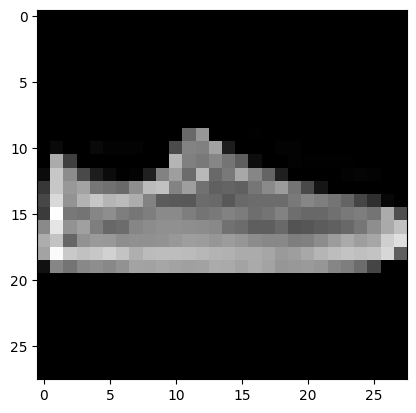

In [110]:
# An really tough one it tends to fail (MNIST 8 FASHION 12)
test_prediction(12, W1, b1, W2, b2, test_data, test_labels)
